In [34]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
import warnings
warnings.filterwarnings("ignore")

## Load Image Data

In [21]:
#load image data
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


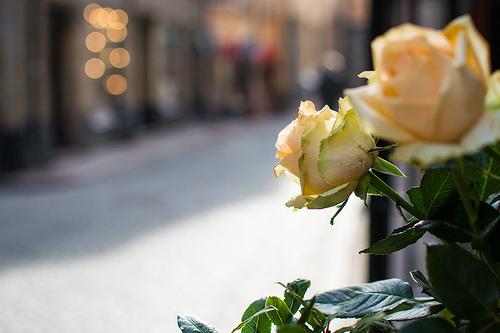

In [26]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[32]))

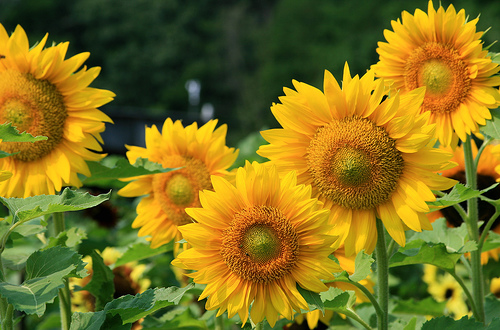

In [27]:
sunflowers = list(data_dir.glob('sunflowers/*'))
PIL.Image.open(str(sunflowers[0]))

## Split the data
We will use validation split,here I am using 80% of the images for training, and 20% for validation.

In [28]:
batch_size = 32
img_height = 180
img_width = 180

In [29]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [30]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [31]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualize the data

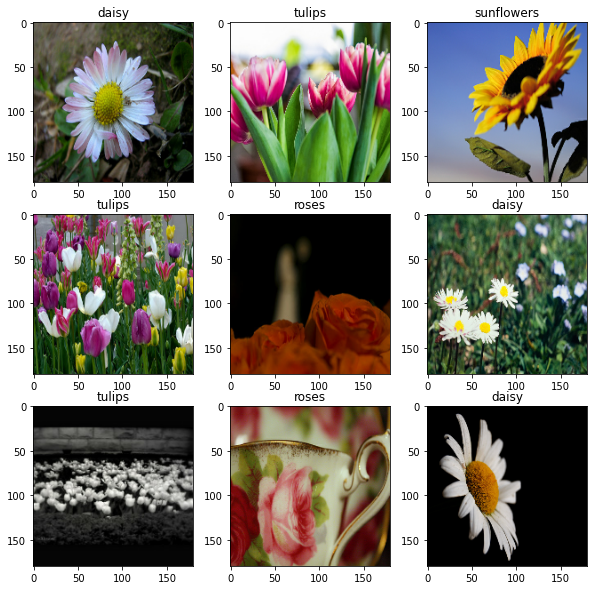

In [35]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])


In [36]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [38]:
#buffered prefetching so we can yield data from disk without having I/O become blocking
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create the model

In [40]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)), #standardizing the data
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [41]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

## Train the model

In [43]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 59s 644ms/step - loss: 1.2231 - accuracy: 0.4884 - val_loss: 1.1072 - val_accuracy: 0.5368
Epoch 2/10
92/92 [==============================] - 57s 615ms/step - loss: 0.9581 - accuracy: 0.6287 - val_loss: 1.0137 - val_accuracy: 0.5940
Epoch 3/10
92/92 [==============================] - 65s 708ms/step - loss: 0.7606 - accuracy: 0.7142 - val_loss: 0.9439 - val_accuracy: 0.6499
Epoch 4/10
92/92 [==============================] - 64s 697ms/step - loss: 0.5364 - accuracy: 0.8025 - val_loss: 1.0331 - val_accuracy: 0.6226
Epoch 5/10
92/92 [==============================] - 58s 633ms/step - loss: 0.3332 - accuracy: 0.8866 - val_loss: 1.1187 - val_accuracy: 0.6199
Epoch 6/10
92/92 [==============================] - 54s 591ms/step - loss: 0.2100 - accuracy: 0.9329 - val_loss: 1.3168 - val_accuracy: 0.6104
Epoch 7/10
92/92 [==============================] - 59s 638ms/step - loss: 0.1491 - accuracy: 0.9567 - val_loss: 1.6004 - val_accuracy: 0.6294

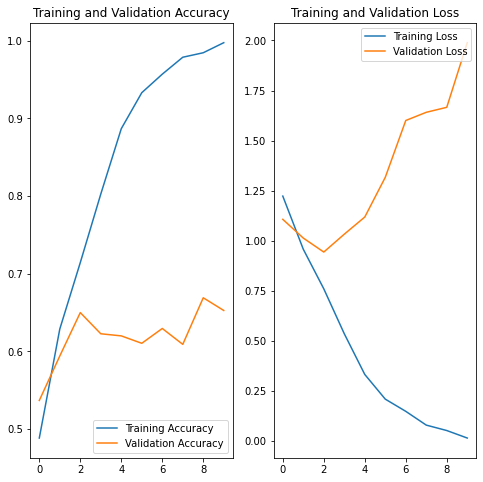

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

the difference in accuracy between training and validation accuracy is noticeable—a sign of overfitting.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting

Data augmentation takes the approach of generating additional training data from your existing examples by augmenting then using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

We will implement data augmentation using experimental Keras Preprocessing Layers. These can be included inside your model like other layers, and run on the GPU.

In [45]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

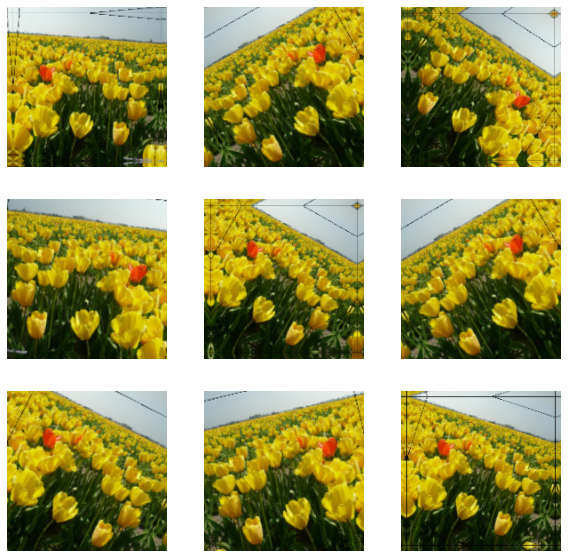

In [50]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
      for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")



In [51]:
#dropout technique
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [52]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [53]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [54]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 55s 596ms/step - loss: 1.4195 - accuracy: 0.3839 - val_loss: 1.1206 - val_accuracy: 0.5095
Epoch 2/15
92/92 [==============================] - 62s 670ms/step - loss: 1.1344 - accuracy: 0.5153 - val_loss: 1.0641 - val_accuracy: 0.5708
Epoch 3/15
92/92 [==============================] - 64s 692ms/step - loss: 1.0105 - accuracy: 0.6110 - val_loss: 1.0201 - val_accuracy: 0.6172
Epoch 4/15
92/92 [==============================] - 73s 792ms/step - loss: 0.9403 - accuracy: 0.6451 - val_loss: 0.9364 - val_accuracy: 0.6499
Epoch 5/15
92/92 [==============================] - 66s 715ms/step - loss: 0.8821 - accuracy: 0.6533 - val_loss: 0.9555 - val_accuracy: 0.6253
Epoch 6/15
92/92 [==============================] - 63s 687ms/step - loss: 0.8312 - accuracy: 0.6819 - val_loss: 0.8743 - val_accuracy: 0.6676
Epoch 7/15
92/92 [==============================] - 62s 676ms/step - loss: 0.7953 - accuracy: 0.6986 - val_loss: 0.8511 - val_accuracy: 0.6771

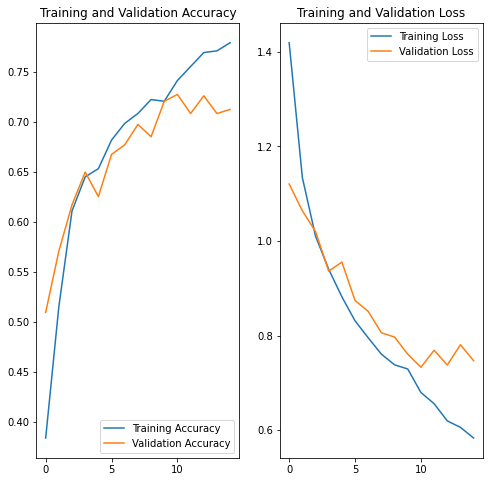

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



In [58]:
sunflower_path = 'sunflower.jpg'

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to sunflowers with a 54.60 percent confidence.


In [57]:
rose_url = "rose.png"

img = keras.preprocessing.image.load_img(
    rose_url, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to roses with a 94.10 percent confidence.


In [59]:
tulip_url = "tulip.jpg"

img = keras.preprocessing.image.load_img(
    tulip_url, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to dandelion with a 44.92 percent confidence.


In [60]:
Dandelion_url = "Dandelion.jpg"

img = keras.preprocessing.image.load_img(
    Dandelion_url, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to dandelion with a 99.81 percent confidence.
